In [28]:
import torch
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

### Load and preprocess images

In [55]:
def load_image(filepath):
    # Load the original image using OpenCV
    image = cv2.imread(filepath)
    
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image_rgb

In [6]:
# Parse the annotation files
def load_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x, y, width, height = map(float, line.strip().split())
            boxes.append([class_id, x, y, width, height])
    return torch.tensor(boxes, dtype=torch.float32)

In [7]:
# Custom dataset class
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(640, 640)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_size = target_size
        self.image_ids = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        img_filename = self.image_ids[index]
        img_path = os.path.join(self.image_dir, img_filename)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_filename)[0] + '.txt')
        
        # Load image and labels
        img = load_image(img_path, target_size=self.target_size)
        boxes = load_labels(label_path)
        
        return img, boxes

In [ ]:
# Initialize the dataset and data loader
train_dataset = YoloDataset(image_dir='People Detection.v8i.yolov8\train\images', 
                            label_dir='People Detection.v8i.yolov8\train\labels', 
                            target_size=(640, 640))
val_dataset = YoloDataset(image_dir='People Detection.v8i.yolov8\valid\images', 
                          label_dir='People Detection.v8i.yolov8\valid\labels', 
                          target_size=(640, 640))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Load pre-trained YOLOv8n model

In [38]:
# Load the pre-trained model (assuming a YOLOv5 PyTorch model)
model = YOLO(r"D:\Projects\P04_Bounding_Box_Pedestrian\trained_model\best.pt")
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### Define training loop

In [ ]:
def train(model, train_loader, val_loader, epochs=10, device='cuda', lr0=0.002, momentum=0.937):
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr0)
    print(f"Using optimizer: Adam(lr={lr0})")

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader)}')


### Train the model

In [ ]:
# Train the model
train(model, train_loader, val_loader, epochs=10, lr0 = 0.002)

### Prediction

In [60]:
def load_image(filepath):
    # Load the original image using OpenCV
    image = cv2.imread(filepath)
    
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image_rgb

In [62]:
def draw_bounding_boxes(image_rgb, results, model):
    people_count = 0
    
    for result in results:
        people_count += sum(1 for cls in result.boxes.cls if model.names[int(cls)] == 'person')

    # Draw bounding boxes on the image
    for result in results[0].boxes:
        box = result.xyxy[0].cpu().numpy()  # Get the bounding box coordinates
        cls = int(result.cls[0])  # Get the class index
        label = model.names[cls]  # Get the class name
        
        if label == 'person':
            # Draw a rectangle for people using Matplotlib
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]),  # (x, y)
                box[2] - box[0],  # width
                box[3] - box[1],  # height
                fill=False,
                edgecolor='red',
                linewidth=2
            ))
            plt.text(box[0], box[1] - 10, label, color='red', fontsize=12)

    # Display the image with bounding boxes
    plt.imshow(image_rgb) 
    plt.axis('off')
    plt.title(f'People Count: {people_count}') 
    plt.show()



image 1/1 c:\Users\Vaibhavkr_07\Downloads\CrossWalk_(5465840138).jpg: 448x640 22 persons, 36.4ms
Speed: 1.9ms preprocess, 36.4ms inference, 7.1ms postprocess per image at shape (1, 3, 448, 640)


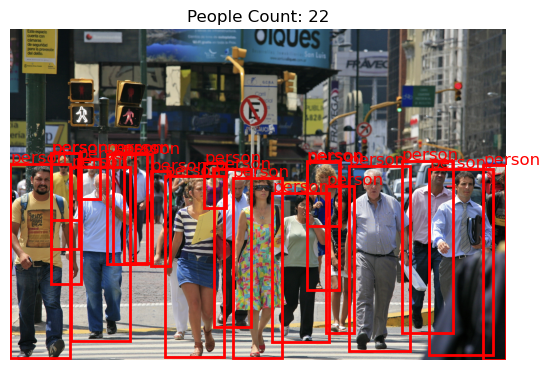

In [63]:
filepath = r"c:\Users\Vaibhavkr_07\Downloads\CrossWalk_(5465840138).jpg"

results = model.predict(filepath) 
image_rgb = load_image(filepath)
draw_bounding_boxes(image_rgb, results, model)